
# Applied AI • fast.ai Starter (CPU) — Jake's Notebook

Welcome! This notebook is pre-wired for local, CPU-only fast.ai practice using your `.applied_ai` env.  
It includes:
- a quick environment check,
- a tiny **MNIST Sample** training run,
- simple interpretation,
- a **personalized run logger** that appends results to a CSV for easy tracking,
- and some light personalization cells you can tweak.

> Tip: Use the **Python (.applied_ai)** kernel when opening this notebook.


In [1]:

from datetime import datetime
import platform, os

now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

print("Python:", platform.python_version())
print("CPU threads available:", os.cpu_count())



Python: 3.12.3
CPU threads available: 16


In [2]:

import torch, fastai
print("torch:", torch.__version__)
print("fastai:", fastai.__version__)
print("GPU available (torch.cuda.is_available):", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Note: This notebook is set up for CPU, but GPU is fine too!")
else:
    print("Running on CPU (expected).")


torch: 2.8.0+cpu
fastai: 2.8.4
GPU available (torch.cuda.is_available): False
Running on CPU (expected).


In [3]:

import os, torch

# Use a sensible number of threads for a snappy local experience
n_threads = max(2, min(8, (os.cpu_count() or 4)//2))
os.environ["OMP_NUM_THREADS"] = str(n_threads)
os.environ["MKL_NUM_THREADS"] = str(n_threads)
torch.set_num_threads(n_threads)

print("Configured threads:", n_threads)


Configured threads: 8


In [4]:

from fastai.vision.all import *
SEED = 42

set_seed(SEED, reproducible=True)
path = untar_data(URLs.MNIST_SAMPLE)   # small, quick to download
dls = ImageDataLoaders.from_folder(path, valid='valid', bs=64, num_workers=2)

# Peek at a few items
list(dls.train.items)[:3], list(dls.valid.items)[:3]


([Path('/home/jake/.fastai/data/mnist_sample/train/3/34089.png'),
  Path('/home/jake/.fastai/data/mnist_sample/train/3/57056.png'),
  Path('/home/jake/.fastai/data/mnist_sample/train/3/21359.png')],
 [Path('/home/jake/.fastai/data/mnist_sample/valid/3/6563.png'),
  Path('/home/jake/.fastai/data/mnist_sample/valid/3/9157.png'),
  Path('/home/jake/.fastai/data/mnist_sample/valid/3/5878.png')])

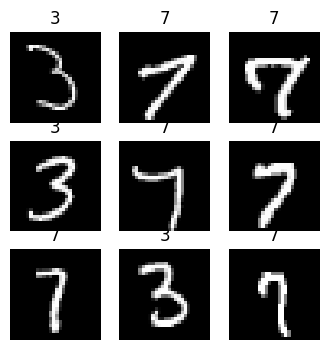

In [5]:

dls.show_batch(max_n=9, figsize=(4,4))


In [6]:

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn


In [ ]:

# lr_min, lr_steep = learn.lr_find()
# lr_min, lr_steep


In [7]:

learn.fine_tune(1)


epoch,train_loss,valid_loss,accuracy,time
0,0.289801,0.148384,0.941119,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.041748,0.024457,0.992640,00:17


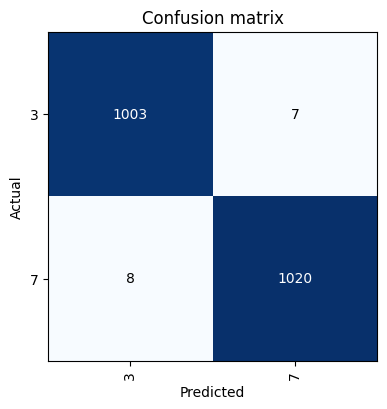

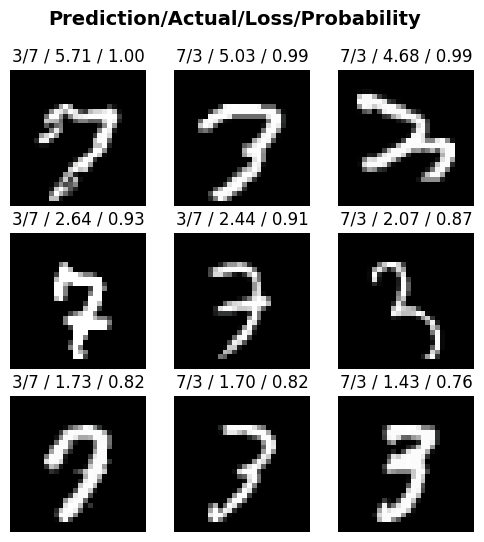

In [8]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4))
interp.plot_top_losses(9, nrows=3, figsize=(6,6))


In [9]:

from pathlib import Path
import shutil

RUN_TAG   = "mnist_sample"

model_name = f"{RUN_TAG}-resnet18"
learn.save(model_name)
export_path = Path(model_name + ".pkl")
learn.export(export_path)
print("Saved model to:", export_path.resolve())

# Copy to /mnt/data for easy download (if available)
try:
    dst = Path("/mnt/data") / export_path.name
    shutil.copy2(export_path, dst)
    print("Also copied to:", dst)
except Exception as e:
    print("Copy to /mnt/data skipped:", e)


Saved model to: /home/jake/Devlopment/applied_AI/mnist_sample-resnet18.pkl
Copy to /mnt/data skipped: [Errno 2] No such file or directory: 'mnist_sample-resnet18.pkl'


In [13]:

import pandas as pd
from pathlib import Path
from datetime import datetime

# --- collect metrics (your snippet) ---
metrics = learn.validate()   # [valid_loss, accuracy]
valid_loss = float(metrics[0])
acc = float(metrics[1]) if len(metrics) > 1 else None
epochs_completed = len(getattr(learn.recorder, "values", []))

row = {
    "timestamp_utc": datetime.utcnow().isoformat(timespec="seconds"),
    "run_tag": RUN_TAG,            # make sure RUN_TAG is defined earlier
    "model": "resnet18",
    "epochs": epochs_completed,
    "valid_loss": valid_loss,
    "accuracy": acc,
}

# --- append to CSV (creates folder/file if needed) ---
metrics_dir = Path("metrics")
metrics_dir.mkdir(parents=True, exist_ok=True)
csv_path = metrics_dir / "fastai_run_metrics.csv"

write_header = not csv_path.exists()
pd.DataFrame([row]).to_csv(
    csv_path, index=False, mode="a", header=write_header, encoding="utf-8"
)

print(f"Logged to: {csv_path.resolve()}")

# --- show recent runs ---
try:
    display(pd.read_csv(csv_path).tail(10))
except Exception as e:
    print("Could not display leaderboard:", e)



Logged to: /home/jake/Devlopment/applied_AI/metrics/fastai_run_metrics.csv


/tmp/ipykernel_179024/2555270121.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp_utc": datetime.utcnow().isoformat(timespec="seconds"),


,timestamp_utc,run_tag,model,epochs,valid_loss,accuracy
0,2025-08-27T01:48:49,mnist_sample,resnet18,1,0.024457,0.99264


In [ ]:

import random
mantras = [
    "Small wins compound. Keep going.",
    "Data > opinions. Measure, then optimize.",
    "Focus is your force multiplier.",
    "Slower is smoother. Smoother is faster.",
    "Ship it. Iterate. Improve."
]
print("MOTD:", random.choice(mantras))


MOTD: Smooth is fast. Fast is smooth.


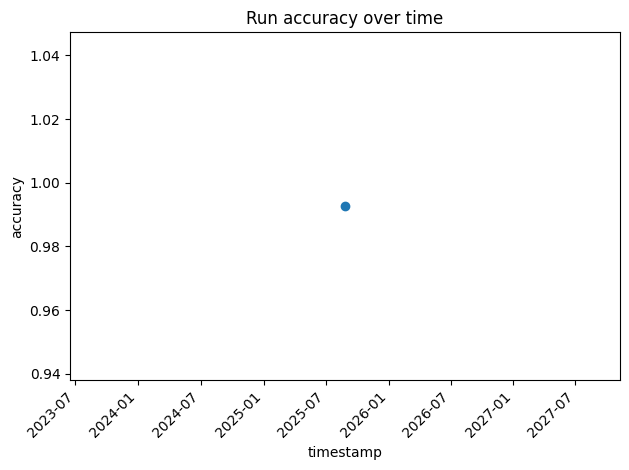

In [15]:
import matplotlib.pyplot as plt
df = pd.read_csv(csv_path, parse_dates=["timestamp_utc"])
df = df.sort_values("timestamp_utc")
plt.figure()
plt.plot(df["timestamp_utc"], df["accuracy"], marker="o")
plt.title("Run accuracy over time")
plt.xlabel("timestamp")
plt.ylabel("accuracy")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
from fastai.vision.all import *
RUN_TAG = "mnist_aug_128"

path = untar_data(URLs.MNIST_SAMPLE)
dls = ImageDataLoaders.from_folder(
    path, valid='valid', bs=64, num_workers=2,
    item_tfms=Resize(128),
    batch_tfms=[*aug_transforms(do_flip=False), Normalize.from_stats(*imagenet_stats)]
)
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(2, base_lr=3e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.098505,0.036650,0.989696,03:26


epoch,train_loss,valid_loss,accuracy,time


In [ ]:
RUN_TAG = "mnist_tuned"
lr_min, lr_steep = learn.lr_find()
learn.fine_tune(3, base_lr=lr_min)
